In [76]:
import xarray as xr
import numpy as np
import os


In [184]:
HTI_forecasted_count = xr.open_dataset("source_disk/MEPS/HTI_forecast/HTI_20161108T00Z.nc")["helicopter_triggered_index"]
os.listdir("source_disk/MEPS/HTI_forecast/")[1200]

'HTI_20170907T00Z.nc'

In [185]:
yellow = HTI_forecasted_count.isel(time=0)*0        ; treshold_yellow = 0.73
brown  = HTI_forecasted_count.isel(time=0)*0        ; treshold_brown  = 0.90
red    = HTI_forecasted_count.isel(time=0)*0        ; treshold_red    = 0.99

In [186]:
temp = []

In [188]:
k = 0
for file in os.listdir("source_disk/MEPS/HTI_forecast/")[1100:]:
    if file.endswith(".nc"):
        k +=1
        HTI_forecasted_count = xr.open_dataset("source_disk/MEPS/HTI_forecast/"+file)["helicopter_triggered_index"]
        try:
            yellow += np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
            brown  += np.sum(HTI_forecasted_count > treshold_brown,axis=0)
            red    += np.sum(HTI_forecasted_count > treshold_red,axis=0)
        except MergeError:
            temp.append([yellow,brown,red])
            yellow = np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
            brown  = np.sum(HTI_forecasted_count > treshold_brown,axis=0)
            red    = np.sum(HTI_forecasted_count > treshold_red,axis=0)
    if k%20 == 0:
        print(k)



NameError: name 'MergeError' is not defined

In [167]:
file = os.listdir("source_disk/MEPS/HTI_forecast/")[1200]
HTI_forecasted_count = xr.open_dataset("source_disk/MEPS/HTI_forecast/"+file)["helicopter_triggered_index"]
yellow_2 = HTI_forecasted_count.isel(time=0)*0
yellow_2 += np.sum(HTI_forecasted_count > treshold_yellow,axis=0)

In [178]:
test = yellow_2.sel(x= yellow.x,method='nearest')


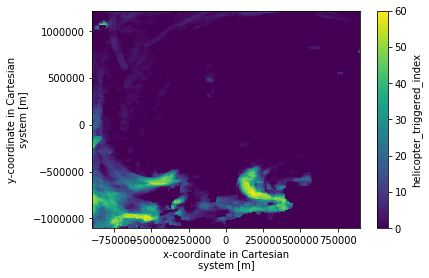

In [181]:
(yellow.reset_coords("time",drop=1) + test.values).plot()

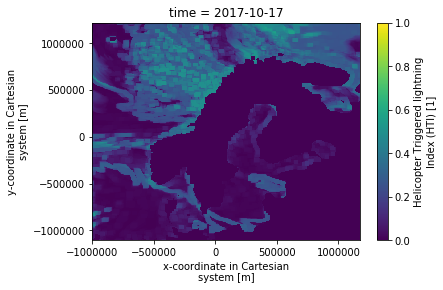

In [91]:
HTI_forecasted_count.isel(time=0).plot(vmin=0,vmax=1)